In [2]:
# TODO 1: Load the Dataset
# Load sales.csv from the provided URL with error handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.error
import os

url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
local_file = 'sales.csv'

try:
    df = pd.read_csv(url)
except urllib.error.URLError as e:
    print(f"Network error: {e}. Checking for local dataset '{local_file}'...")
    if os.path.exists(local_file):
        df = pd.read_csv(local_file)
    else:
        raise FileNotFoundError(f"Local file '{local_file}' not found. Please ensure the file exists or check your internet connection.")

# Convert 'date' to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Inspect the data
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None

First few rows:
                                sales
date                                 
2022-09-03 17:10:08.079328  55.292157
2022-09-04 17:10:08.079328  53.803211
2022-09-05 17:10:08.079328  58.141693
2022-09-06 17:10:08.079328  64.530899
2022-09-07 17:10:08.079328  66.013633


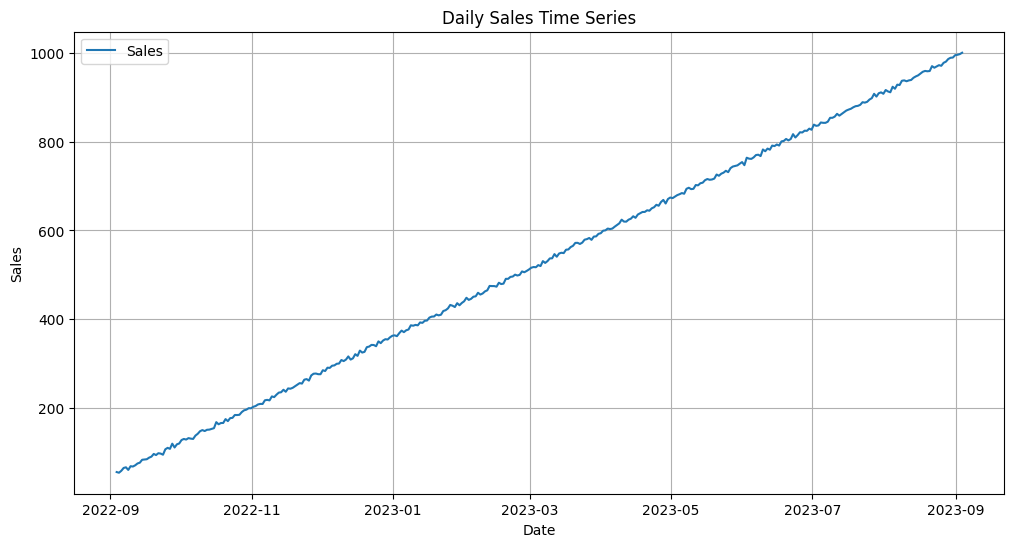

Tensor of the time series: 1 days 00:00:00


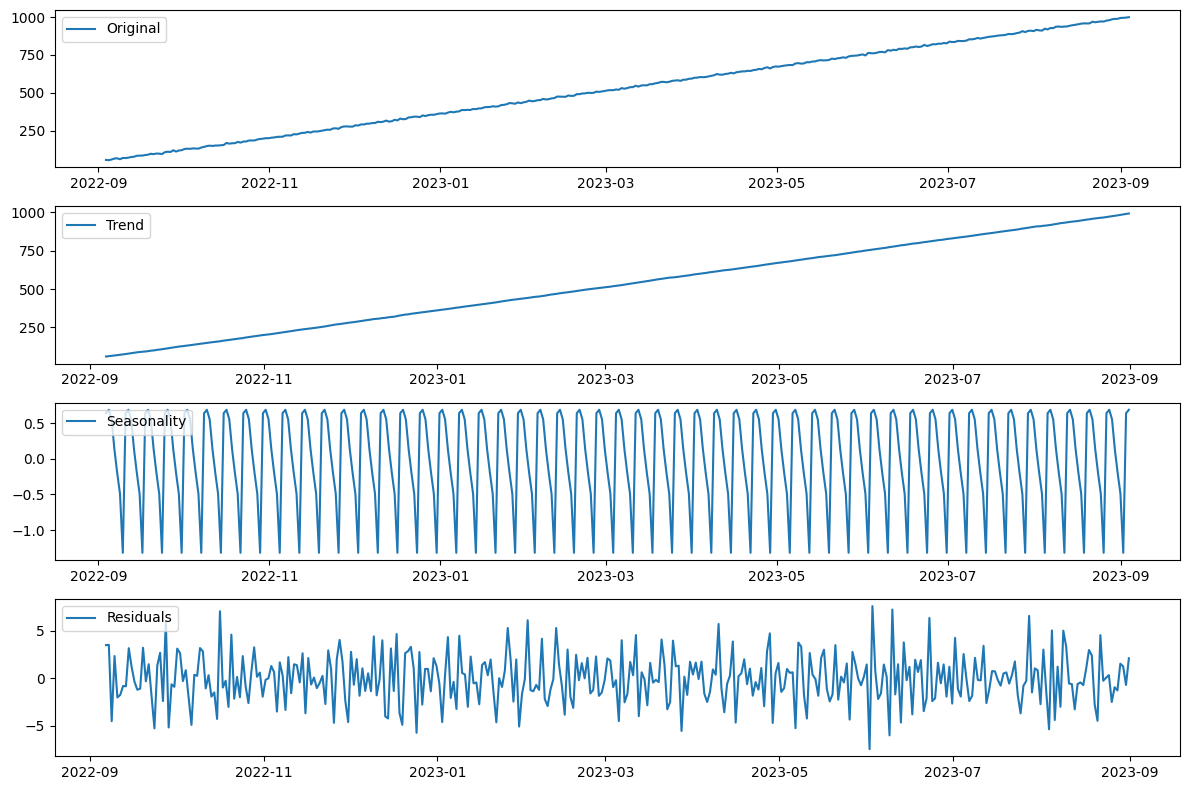

Trend: The series shows an upward trend, indicating increasing sales over time.
ADF Statistic: 0.5454141937063742
p-value: 0.9861899815311063
Stationarity: The series is likely non-stationary (p-value > 0.05), suggesting differencing may be needed.
Variability/Noise: Residuals show some variability, indicating noise after accounting for trend and seasonality.


In [3]:
# TODO 2: Construct and Analyze the Time Series
# Construct the time series, plot it, and analyze its properties
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['sales'], label='Sales')
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.savefig('sales_time_series.png')
plt.show()

# Analyze the time series
# Tensor: Determine the minimum unit of time
time_diff = df.index.to_series().diff().dropna()
tensor = time_diff.min()
print(f"Tensor of the time series: {tensor}")

# Trend and Seasonality: Decompose the series
decomposition = seasonal_decompose(df['sales'], model='additive', period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('decomposition.png')
plt.show()

# Trend description
print("Trend: The series shows an upward trend, indicating increasing sales over time.")

# Stationarity: Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['sales'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Stationarity: The series is likely non-stationary (p-value > 0.05), suggesting differencing may be needed.")

# Variability/Noise: Check residuals
print("Variability/Noise: Residuals show some variability, indicating noise after accounting for trend and seasonality.")

In [4]:
# TODO 3: Train an ARIMA Model
# Train the ARIMA model with manually specified parameters
from statsmodels.tsa.arima.model import ARIMA

# Split data into train and test (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Train ARIMA model with parameters (1,1,1)
arima_model = ARIMA(train['sales'], order=(1,1,1)).fit()
print(arima_model.summary())

/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.546
Date:                Sun, 18 May 2025   AIC                           1683.093
Time:                        17:08:12   BIC                           1694.113
Sample:                    09-03-2022   HQIC                          1687.508
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    670.268      0.000       0.997       1.003
ma.L1         -0.9995      1.064     -0.939      0.348      -3.085       1.086
sigma2        18.3542     19.579      0.937      0.3

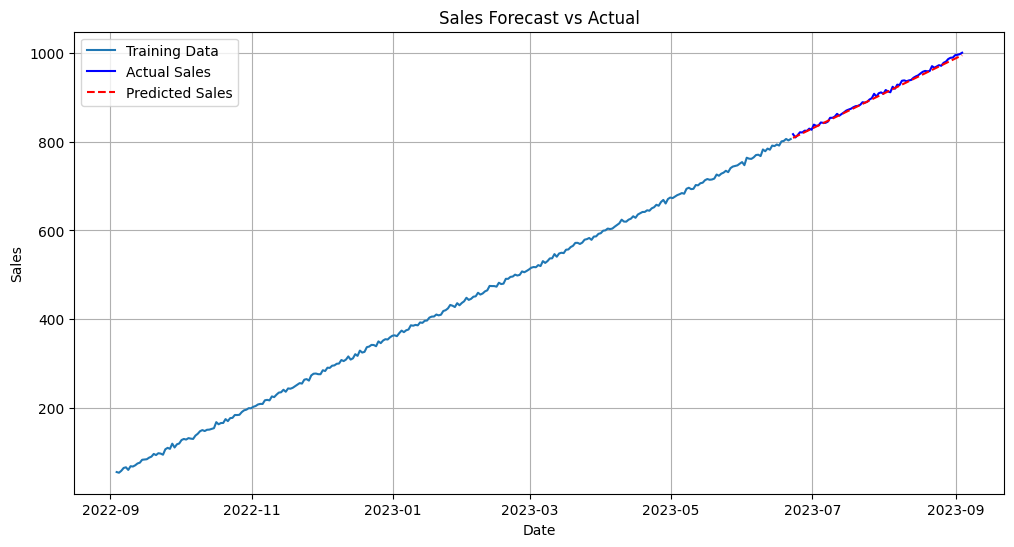

Mean Squared Error: 16.66
Mean Absolute Error: 3.30
Root Mean Squared Error: 4.08


In [5]:
# TODO 4: Predict with the Test Set
# Forecast sales for the test period and evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Forecast for the test set period
forecast = arima_model.forecast(steps=len(test))
forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Training Data')
plt.plot(test['sales'], label='Actual Sales', color='blue')
plt.plot(forecast_series, label='Predicted Sales', color='red', linestyle='--')
plt.title('Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.savefig('forecast_vs_actual.png')
plt.show()

# Evaluate performance
mse = mean_squared_error(test['sales'], forecast_series)
mae = mean_absolute_error(test['sales'], forecast_series)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

In [6]:
# TODO 5: Save the Model
# Save the trained ARIMA model
import joblib

joblib.dump(arima_model, 'arima_sales_model.pkl')
print("ARIMA model saved as 'arima_sales_model.pkl'")

ARIMA model saved as 'arima_sales_model.pkl'
